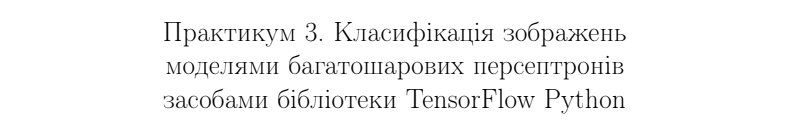

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.datasets import mnist 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import os, datetime

Для того, щоб можна було запускати TensorBoard

In [2]:
%load_ext tensorboard

In [18]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

In [3]:
print("Training matrix shape", X_train.shape)
print("Valid matrix shape", X_valid.shape)

Training matrix shape (60000, 28, 28)
Valid matrix shape (10000, 28, 28)


In [39]:
X_train = X_train.astype('float32').reshape(-1, 28*28) / 255.0
X_valid = X_valid.astype('float32').reshape(-1, 28*28) / 255.0
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)

In [6]:
print("Training matrix shape", X_train.shape)

Training matrix shape (60000, 784)


Застосуємо One Hot Encoder для кращого навчанння наших даних.

In [40]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()

ohe.fit(y_train)
y_train = ohe.transform(y_train).toarray()

ohe.fit(y_valid)
y_valid = ohe.transform(y_valid).toarray()

In [8]:
y_valid.shape

(10000, 10)

In [11]:
metrics = [
    'accuracy',
    F1Score(10, average='macro', name='f1'),
    tf.keras.metrics.AUC(name='auc')
]

### Baseline model - softmax layer

In [12]:
normal_init = tf.random_normal_initializer(mean=0.0, stddev=1.0)
    
baseline_model = keras.Sequential([
    layers.Dense(10, input_shape=(28*28,),
                 activation='softmax',
                 kernel_initializer=normal_init)
    ])

baseline_model.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
)

logdir = "logs/base"
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = baseline_model.fit(X_train,y_train, 
                             validation_data=(X_valid, y_valid),
                            epochs=30,
                            callbacks=[tensorboard_callback])

Epoch 1/30


2022-05-09 17:32:23.255814: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 4s 2ms/step - loss: 4.8219 - accuracy: 0.3881 - f1: 0.3829 - auc: 0.7435 - val_loss: 2.3786 - val_accuracy: 0.5954 - val_f1: 0.5892 - val_auc: 0.8734
Epoch 2/30
1875/1875 [==============================] - 2s 1ms/step - loss: 1.9246 - accuracy: 0.6537 - f1: 0.6491 - auc: 0.8989 - val_loss: 1.5373 - val_accuracy: 0.7133 - val_f1: 0.7085 - val_auc: 0.9247
Epoch 3/30
1875/1875 [==============================] - 2s 1ms/step - loss: 1.4150 - accuracy: 0.7314 - f1: 0.7275 - auc: 0.9303 - val_loss: 1.2382 - val_accuracy: 0.7652 - val_f1: 0.7607 - val_auc: 0.9424
Epoch 4/30
1875/1875 [==============================] - 2s 1ms/step - loss: 1.1879 - accuracy: 0.7688 - f1: 0.7655 - auc: 0.9438 - val_loss: 1.0772 - val_accuracy: 0.7901 - val_f1: 0.7863 - val_auc: 0.9508
Epoch 5/30
1875/1875 [==============================] - 2s 1ms/step - loss: 1.0552 - accuracy: 0.7906 - f1: 0.7876 - auc: 0.9513 - val_loss: 0.9759 - val_accuracy: 0.8077 - val_f1: 0.8044

In [13]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.520202
accuracy        0.879833
f1              0.878075
auc             0.979712
val_loss        0.510692
val_accuracy    0.882300
val_f1          0.880546
val_auc         0.979887
dtype: float64

In [ ]:
%tensorboard --logdir logs  #для відображення TensorBoard в notebook

Коли ми навчаємо модель, ми робимо графік втрати на навчальному наборі епоху за епохою. А також додаємо графік даних перевірки. Ці графіки називаються кривими навчання.

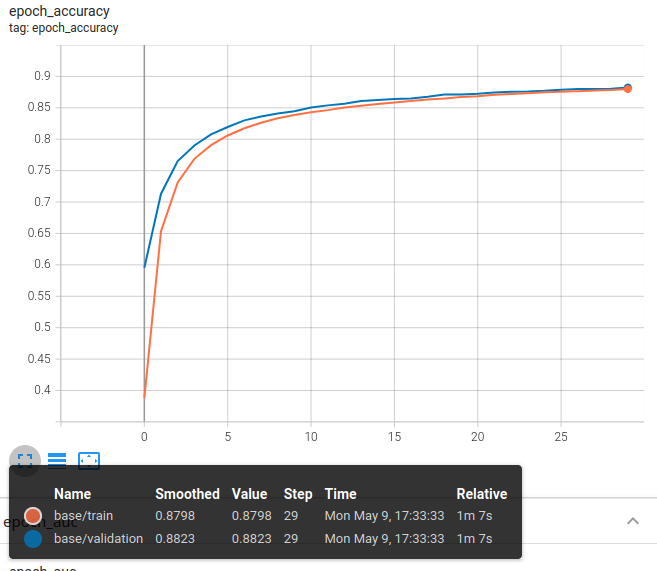
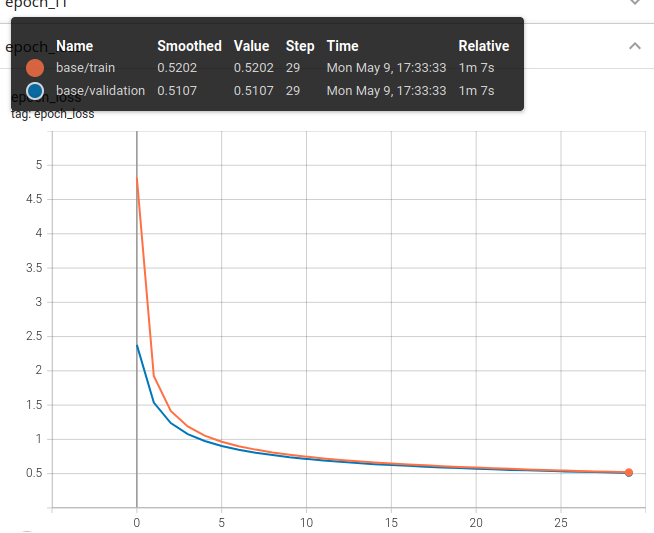

**далі буду відображувати графіки безпосередньо в python*

#### Порівняємо ReLU і tanh

In [16]:
def model_define(initializer, activation, learning_rate=0.01,  input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.Dense(256, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(units=10, activation='softmax'),
    ])

    opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)
    
    return model, history

In [17]:
initializer_glorot = tf.initializers.GlorotNormal()
activation_tanh = 'tanh'

model_tanh, history_tanh = model_define(initializer_glorot, activation_tanh, 
                              input_shape=[28*28])

Epoch 1/30


2022-05-09 17:35:04.826038: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 7s 3ms/step - loss: 0.4958 - accuracy: 0.8684 - f1: 0.8683 - auc: 0.9844 - val_loss: 0.3147 - val_accuracy: 0.9121 - val_f1: 0.9108 - val_auc: 0.9923
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3065 - accuracy: 0.9128 - f1: 0.9115 - auc: 0.9925 - val_loss: 0.2756 - val_accuracy: 0.9220 - val_f1: 0.9209 - val_auc: 0.9935
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2701 - accuracy: 0.9233 - f1: 0.9223 - auc: 0.9937 - val_loss: 0.2497 - val_accuracy: 0.9292 - val_f1: 0.9282 - val_auc: 0.9945
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2448 - accuracy: 0.9299 - f1: 0.9291 - auc: 0.9946 - val_loss: 0.2315 - val_accuracy: 0.9323 - val_f1: 0.9315 - val_auc: 0.9951
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2229 - accuracy: 0.9368 - f1: 0.9361 - auc: 0.9952 - val_loss: 0.2104 - val_accuracy: 0.9391 - val_f1: 0.9383

In [18]:
pd.Series({k:v[-1] for k, v in history_tanh.history.items()})

loss            0.055502
accuracy        0.985150
f1              0.985075
auc             0.999573
val_loss        0.081832
val_accuracy    0.973800
val_f1          0.973630
val_auc         0.999032
dtype: float64

In [19]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['accuracy', 'val_accuracy']].plot()

Maximum accuracy: 0.974399983882904


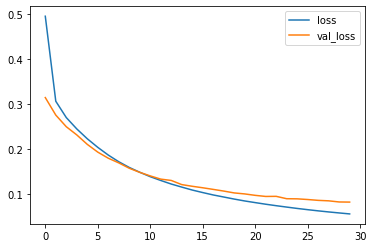

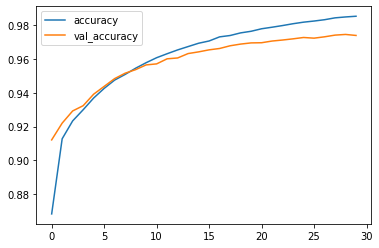

In [20]:
plot_loss_accuraccy(history_tanh)

In [21]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

model_relu, history_relu = model_define(initializer_he, activation_relu, 
                              input_shape=[28*28])

model_relu.save('models/model_relu')

Epoch 1/30


2022-05-09 17:38:03.172851: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 7s 3ms/step - loss: 0.4991 - accuracy: 0.8686 - f1: 0.8821 - auc: 0.9893 - val_loss: 0.2775 - val_accuracy: 0.9226 - val_f1: 0.9216 - val_auc: 0.9940
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2577 - accuracy: 0.9267 - f1: 0.9258 - auc: 0.9945 - val_loss: 0.2164 - val_accuracy: 0.9385 - val_f1: 0.9377 - val_auc: 0.9957
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2074 - accuracy: 0.9410 - f1: 0.9404 - auc: 0.9961 - val_loss: 0.1854 - val_accuracy: 0.9451 - val_f1: 0.9445 - val_auc: 0.9970
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1740 - accuracy: 0.9505 - f1: 0.9499 - auc: 0.9971 - val_loss: 0.1642 - val_accuracy: 0.9508 - val_f1: 0.9503 - val_auc: 0.9973
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1501 - accuracy: 0.9577 - f1: 0.9573 - auc: 0.9977 - val_loss: 0.1429 - val_accuracy: 0.9595 - val_f1: 0.9591

2022-05-09 17:40:59.191978: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_relu/assets


In [22]:
pd.Series({k:v[-1] for k, v in history_relu.history.items()})

loss            0.021162
accuracy        0.996033
f1              0.996051
auc             0.999914
val_loss        0.064970
val_accuracy    0.977500
val_f1          0.977306
val_auc         0.998874
dtype: float64

Maximum accuracy: 0.978600025177002


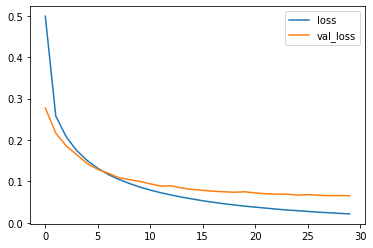

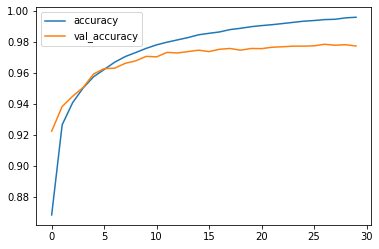

In [23]:
plot_loss_accuraccy(history_relu)

Отже, з вище проведених іналіз даних можна зробити висновок, що найкращу модель отримали під час ініціалізації ваг методом Хе при значенні accuracy: 0.978 далі іде ініціалізації ваг методом Глоро - accuracy: 0.974 і далі традиційна із accuracy: 0.88.

Дані графіках кривих навчання показують наскільки ефективно начаются моделі. Функції втрат прямують до 0, а accuracy до 1. </br>
У випадку коли модель навчається довго, то виникає проблема переначання, коли модель враховує великує частину шуму і врешті не здатна коректно прогозувати дані. Тобто в даному випадку фунція втрат на навчальних даних продовжує прямувати до 0, а на даних перевірці(x_valid) почне зростати. І в протилежному випадку на графіках accuracy.

Серед наведених вище графіках переначання не спостерігається.

##### Дослідимо різні функції активації: LeakyReLU, Parametric LeakyReLU, ELU.

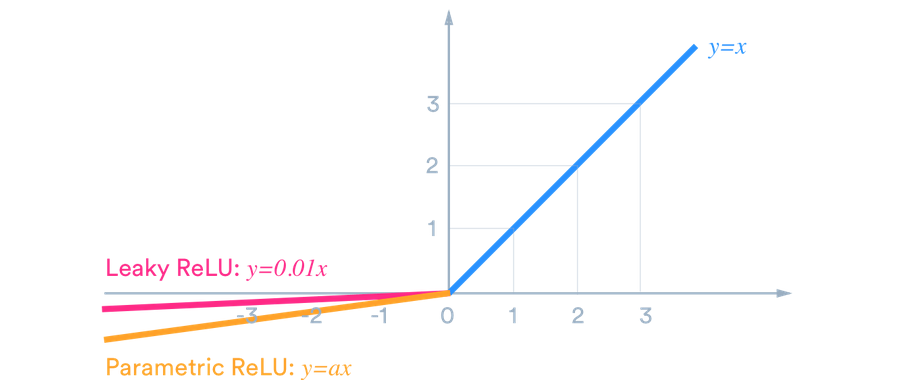
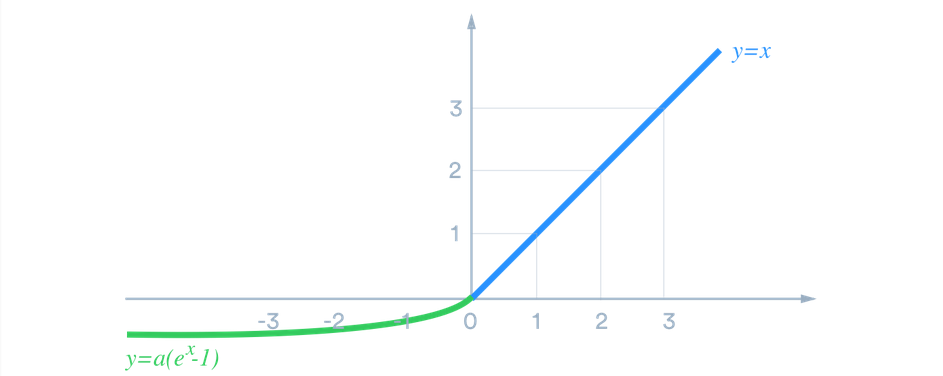

#### Для LeakyReLU

In [24]:
activation_lrelu = layers.LeakyReLU()

model_lrelu, history_lrelu = model_define(initializer_he, activation_lrelu, 
                              input_shape=[28*28])

model_lrelu.save('models/model_lrelu')

Epoch 1/30
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4920 - accuracy: 0.8694 - f1: 0.8832 - auc: 0.9893 - val_loss: 0.2978 - val_accuracy: 0.9146 - val_f1: 0.9131 - val_auc: 0.9928
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2785 - accuracy: 0.9208 - f1: 0.9198 - auc: 0.9935 - val_loss: 0.2428 - val_accuracy: 0.9314 - val_f1: 0.9304 - val_auc: 0.9945
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2354 - accuracy: 0.9324 - f1: 0.9316 - auc: 0.9950 - val_loss: 0.2136 - val_accuracy: 0.9391 - val_f1: 0.9384 - val_auc: 0.9955
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2052 - accuracy: 0.9415 - f1: 0.9409 - auc: 0.9959 - val_loss: 0.1911 - val_accuracy: 0.9458 - val_f1: 0.9452 - val_auc: 0.9964
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1823 - accuracy: 0.9489 - f1: 0.9485 - auc: 0.9967 - val_loss: 0.1746 - val_accuracy: 0.9492 - val

INFO:tensorflow:Assets written to: models/model_lrelu/assets


INFO:tensorflow:Assets written to: models/model_lrelu/assets


In [25]:
pd.Series({k:v[-1] for k, v in history_lrelu.history.items()})

loss            0.035963
accuracy        0.990850
f1              0.990829
auc             0.999774
val_loss        0.074060
val_accuracy    0.977400
val_f1          0.977255
val_auc         0.998997
dtype: float64

Перевіримо час навчання мережі із функцiєю активацiї LeakyReLU:

In [26]:
%time model_lrelu.fit(X_train, y_train)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0341 - accuracy: 0.9919 - f1: 0.9918 - auc: 0.9998
CPU times: user 15.5 s, sys: 1.21 s, total: 16.7 s
Wall time: 5.2 s


Перевіримо час надання прогнозу

In [27]:
%time y_pred_lrelu = model_lrelu.predict(X_valid)

CPU times: user 942 ms, sys: 51.2 ms, total: 994 ms
Wall time: 851 ms


#### Для Parametric LeakyReLU

In [28]:
activation_prelu = layers.PReLU(alpha_initializer=keras.initializers.Constant(value=0.25))

model_prelu = keras.Sequential([
    layers.Dense(512, input_shape=[28*28],
                 kernel_initializer=initializer_he),
    layers.PReLU(),
    layers.Dense(256, kernel_initializer=initializer_he),
    layers.PReLU(),
    layers.Dense(units=10, activation='softmax'),
    ])

model_prelu.compile(
        optimizer="SGD",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
history = model_prelu.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)

model_prelu.save('models/model_prelu')

Epoch 1/30
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4975 - accuracy: 0.8673 - f1: 0.9287 - auc: 0.9958 - val_loss: 0.2760 - val_accuracy: 0.9223 - val_f1: 0.9212 - val_auc: 0.9939
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2551 - accuracy: 0.9279 - f1: 0.9270 - auc: 0.9947 - val_loss: 0.2150 - val_accuracy: 0.9389 - val_f1: 0.9381 - val_auc: 0.9957
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2045 - accuracy: 0.9431 - f1: 0.9425 - auc: 0.9962 - val_loss: 0.1804 - val_accuracy: 0.9483 - val_f1: 0.9478 - val_auc: 0.9969
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1715 - accuracy: 0.9517 - f1: 0.9513 - auc: 0.9971 - val_loss: 0.1609 - val_accuracy: 0.9535 - val_f1: 0.9530 - val_auc: 0.9974
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1477 - accuracy: 0.9580 - f1: 0.9577 - auc: 0.9977 - val_loss: 0.1451 - val_accuracy: 0.9573 - val

INFO:tensorflow:Assets written to: models/model_prelu/assets


In [29]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.019415
accuracy        0.996317
f1              0.996339
auc             0.999942
val_loss        0.066100
val_accuracy    0.978500
val_f1          0.978366
val_auc         0.998677
dtype: float64

In [30]:
%time model_prelu.fit(X_train, y_train)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0183 - accuracy: 0.9972 - f1: 0.9972 - auc: 0.9999
CPU times: user 16.6 s, sys: 1.21 s, total: 17.8 s
Wall time: 5.38 s


In [31]:
%time y_pred_prelu = model_prelu.predict(X_valid)

CPU times: user 950 ms, sys: 65.8 ms, total: 1.02 s
Wall time: 446 ms


#### Для ELU

In [32]:
activation_elu = layers.ELU()

model_elu, history_elu = model_define(initializer_he, activation_elu, 
                              input_shape=[28*28])

model_elu.save('models/model_elu')

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4463 - accuracy: 0.8764 - f1: 0.9361 - auc: 0.9963 - val_loss: 0.2959 - val_accuracy: 0.9159 - val_f1: 0.9146 - val_auc: 0.9928
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2877 - accuracy: 0.9179 - f1: 0.9168 - auc: 0.9929 - val_loss: 0.2571 - val_accuracy: 0.9268 - val_f1: 0.9260 - val_auc: 0.9941
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2508 - accuracy: 0.9285 - f1: 0.9277 - auc: 0.9942 - val_loss: 0.2357 - val_accuracy: 0.9306 - val_f1: 0.9299 - val_auc: 0.9948
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2217 - accuracy: 0.9375 - f1: 0.9368 - auc: 0.9953 - val_loss: 0.2040 - val_accuracy: 0.9420 - val_f1: 0.9413 - val_auc: 0.9958
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1973 - accuracy: 0.9444 - f1: 0.9439 - auc: 0.9960 - val_loss: 0.1851 - val_accuracy: 0.9469 - val

INFO:tensorflow:Assets written to: models/model_elu/assets


INFO:tensorflow:Assets written to: models/model_elu/assets


In [33]:
pd.Series({k:v[-1] for k, v in history_elu.history.items()})

loss            0.044867
accuracy        0.987783
f1              0.987735
auc             0.999686
val_loss        0.073892
val_accuracy    0.977200
val_f1          0.977016
val_auc         0.998947
dtype: float64

In [34]:
%time model_elu.fit(X_train, y_train)

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0432 - accuracy: 0.9883 - f1: 0.9883 - auc: 0.9997
CPU times: user 15.6 s, sys: 1.22 s, total: 16.8 s
Wall time: 5.31 s


In [36]:
%time y_pred_elu = model_elu.predict(X_valid)

CPU times: user 910 ms, sys: 94.9 ms, total: 1 s
Wall time: 469 ms


Отже ми отримали такі результати: </br>
- Час навчання мережі:
    - LeakyReLU: 16.7 s
    - Parametric LeakyReLU: 17.8
    - ELU: 16.8 s
    
- Якiсть роботи мережi на перевiрочнiй множинi:
    - LeakyReLU: 0.977
    - Parametric LeakyReLU: 0.978
    - ELU: 0.977
- Час надання прогнозу мережею:
    - LeakyReLU: 994 ms
    - Parametric LeakyReLU: 1.02 s
    - ELU: 1 s

#### Далі замiсть методу ґрадiєнтного спуску використаємо адаптивний метод Adam

In [37]:
def model_define_adam(initializer, activation, input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.Dense(256, activation=activation,
                kernel_initializer=initializer),
    layers.Dense(units=10, activation='softmax'),
    ])

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30)
    
    return model, history

#### Normal ініціалізація

In [38]:
initializer_norm = tf.random_normal_initializer(mean=0.0, stddev=1.0)
activation_relu = 'relu'

model_adam_norm, history_adam_norm = model_define_adam(initializer_norm, activation_relu, 
                              input_shape=[28*28])

model_adam_norm.save('models/model_adam_norm')

Epoch 1/30
1875/1875 [==============================] - 7s 4ms/step - loss: 8.7524 - accuracy: 0.8496 - f1: 0.8663 - auc: 0.9346 - val_loss: 2.4886 - val_accuracy: 0.9197 - val_f1: 0.9191 - val_auc: 0.9620
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 1.8282 - accuracy: 0.9317 - f1: 0.9310 - auc: 0.9687 - val_loss: 1.7744 - val_accuracy: 0.9296 - val_f1: 0.9288 - val_auc: 0.9683
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.9732 - accuracy: 0.9483 - f1: 0.9478 - auc: 0.9778 - val_loss: 1.3140 - val_accuracy: 0.9422 - val_f1: 0.9419 - val_auc: 0.9746
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5891 - accuracy: 0.9611 - f1: 0.9607 - auc: 0.9847 - val_loss: 1.0712 - val_accuracy: 0.9475 - val_f1: 0.9471 - val_auc: 0.9786
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4251 - accuracy: 0.9676 - f1: 0.9673 - auc: 0.9881 - val_loss: 1.1251 - val_accuracy: 0.9488 - val

INFO:tensorflow:Assets written to: models/model_adam_norm/assets


In [39]:
pd.Series({k:v[-1] for k, v in history_adam_norm.history.items()})

loss            0.071547
accuracy        0.996317
f1              0.996312
auc             0.998422
val_loss        1.565444
val_accuracy    0.971800
val_f1          0.971493
val_auc         0.985962
dtype: float64

Maximum accuracy: 0.9736999869346619


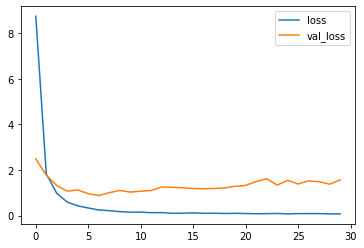

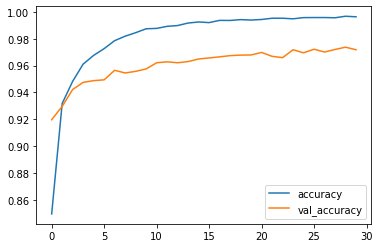

In [40]:
plot_loss_accuraccy(history_adam_norm)

#### Glorot ініціалізація

In [41]:
initializer_glorot = tf.initializers.GlorotNormal()
activation_tanh = 'tanh'

model_adam_glorot, history_adam_glorot = model_define_adam(initializer_glorot, activation_tanh, 
                              input_shape=[28*28])

model_adam_norm.save('models/model_adam_glorot')

Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2247 - accuracy: 0.9316 - f1: 0.9366 - auc: 0.9938 - val_loss: 0.1522 - val_accuracy: 0.9529 - val_f1: 0.9523 - val_auc: 0.9968
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1050 - accuracy: 0.9681 - f1: 0.9678 - auc: 0.9985 - val_loss: 0.1126 - val_accuracy: 0.9665 - val_f1: 0.9662 - val_auc: 0.9979
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0750 - accuracy: 0.9764 - f1: 0.9762 - auc: 0.9991 - val_loss: 0.0889 - val_accuracy: 0.9717 - val_f1: 0.9715 - val_auc: 0.9984
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0582 - accuracy: 0.9811 - f1: 0.9810 - auc: 0.9993 - val_loss: 0.0913 - val_accuracy: 0.9708 - val_f1: 0.9705 - val_auc: 0.9985
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0466 - accuracy: 0.9848 - f1: 0.9847 - auc: 0.9996 - val_loss: 0.0856 - val_accuracy: 0.9732 - val

INFO:tensorflow:Assets written to: models/model_adam_glorot/assets


In [42]:
pd.Series({k:v[-1] for k, v in history_adam_glorot.history.items()})

loss            0.011838
accuracy        0.995933
f1              0.995895
auc             0.999884
val_loss        0.097819
val_accuracy    0.978100
val_f1          0.977944
val_auc         0.996658
dtype: float64

Maximum accuracy: 0.9797999858856201


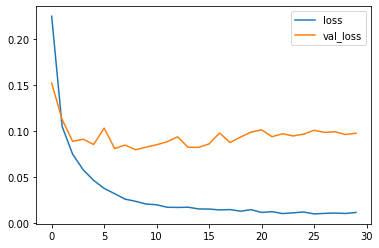

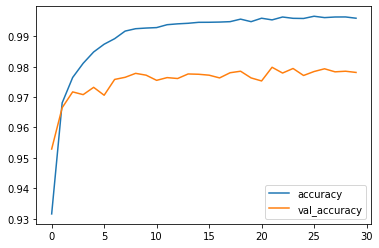

In [43]:
plot_loss_accuraccy(history_adam_glorot)

#### He ініціалізація

In [44]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

model_adam_he, history_adam_he = model_define_adam(initializer_he, activation_relu, 
                              input_shape=[28*28])

model_adam_he.save('models/model_adam_he')

Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1841 - accuracy: 0.9448 - f1: 0.9491 - auc: 0.9966 - val_loss: 0.1130 - val_accuracy: 0.9628 - val_f1: 0.9625 - val_auc: 0.9979
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0800 - accuracy: 0.9751 - f1: 0.9748 - auc: 0.9988 - val_loss: 0.0693 - val_accuracy: 0.9789 - val_f1: 0.9788 - val_auc: 0.9986
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0534 - accuracy: 0.9831 - f1: 0.9829 - auc: 0.9993 - val_loss: 0.0819 - val_accuracy: 0.9757 - val_f1: 0.9754 - val_auc: 0.9982
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0426 - accuracy: 0.9862 - f1: 0.9861 - auc: 0.9995 - val_loss: 0.0874 - val_accuracy: 0.9768 - val_f1: 0.9766 - val_auc: 0.9978
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0322 - accuracy: 0.9894 - f1: 0.9893 - auc: 0.9996 - val_loss: 0.0635 - val_accuracy: 0.9819 - val

INFO:tensorflow:Assets written to: models/model_adam_he/assets


In [45]:
pd.Series({k:v[-1] for k, v in history_adam_he.history.items()})

loss            0.009231
accuracy        0.997700
f1              0.997665
auc             0.999777
val_loss        0.147378
val_accuracy    0.982300
val_f1          0.982146
val_auc         0.994660
dtype: float64

Maximum accuracy: 0.984000027179718


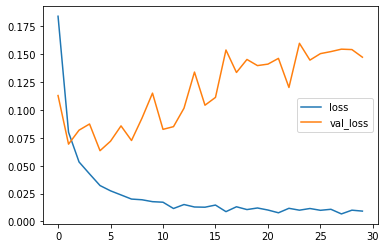

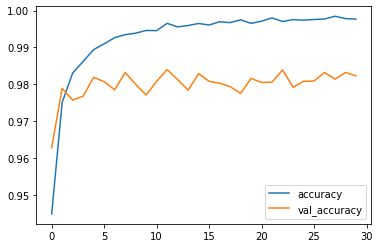

In [46]:
plot_loss_accuraccy(history_adam_he)

In [47]:
%time y_pred = model_adam_he.predict(X_valid)

CPU times: user 855 ms, sys: 65.4 ms, total: 920 ms
Wall time: 564 ms


Accuracy in SGD:
- Normal: 0.8823
- Glorot: 0.9738
- He: 0.9775
 
Accuracy in Adam:
- Normal: 0.9718
- Glorot: 0.9781
- He: 0.9823

Отже, як бачимо якість навчання покращився, але при цьому змінена кількість епох навчання, а отже і швидкість для навчання самої моделі. Тобто алгоритм Adam навчається більш точно і набагато швидше.

#### Далі дослідимо нормалiзацiю за мiнi-батчами

In [48]:
def model_batch(initializer, activation, learning_rate, input_shape=[1]):
    model = keras.Sequential([
    layers.Dense(512, input_shape=input_shape,
                 activation=activation,
                 kernel_initializer=initializer),
    layers.BatchNormalization(),
    layers.Dense(256, activation=activation,
                kernel_initializer=initializer),
    layers.BatchNormalization(),
    layers.Dense(units=10, activation='softmax'),
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        batch_size=64)
    
    
    return model, history

In [49]:
model_batch_he, history_batch_he = model_batch(initializer_he, 
                                               activation_relu,
                                               0.01,
                                               input_shape=[28*28])

model_batch_he.save('models/model_batch_he')

Epoch 1/30
938/938 [==============================] - 8s 6ms/step - loss: 0.1812 - accuracy: 0.9449 - f1: 0.9498 - auc: 0.9963 - val_loss: 0.0939 - val_accuracy: 0.9706 - val_f1: 0.9703 - val_auc: 0.9986
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0802 - accuracy: 0.9750 - f1: 0.9747 - auc: 0.9989 - val_loss: 0.0864 - val_accuracy: 0.9741 - val_f1: 0.9739 - val_auc: 0.9984
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0596 - accuracy: 0.9807 - f1: 0.9805 - auc: 0.9993 - val_loss: 0.0859 - val_accuracy: 0.9720 - val_f1: 0.9718 - val_auc: 0.9986
Epoch 4/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0454 - accuracy: 0.9849 - f1: 0.9847 - auc: 0.9996 - val_loss: 0.0727 - val_accuracy: 0.9770 - val_f1: 0.9768 - val_auc: 0.9987
Epoch 5/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0382 - accuracy: 0.9874 - f1: 0.9873 - auc: 0.9997 - val_loss: 0.0690 - val_accuracy: 0.9787 - val_f1: 0.978

INFO:tensorflow:Assets written to: models/model_batch_he/assets


In [50]:
pd.Series({k:v[-1] for k, v in history_batch_he.history.items()})

loss            0.006227
accuracy        0.997833
f1              0.997823
auc             0.999942
val_loss        0.068225
val_accuracy    0.984300
val_f1          0.984192
val_auc         0.997751
dtype: float64

In [51]:
%time y_pred_batch = model_batch_he.predict(X_valid)

CPU times: user 1.01 s, sys: 53.1 ms, total: 1.06 s
Wall time: 527 ms


Maximum accuracy: 0.9843000173568726


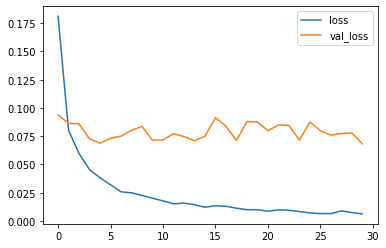

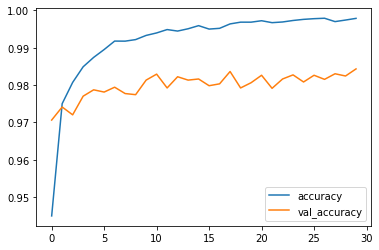

In [52]:
plot_loss_accuraccy(history_batch_he)

Отже з отриманих результатыв отримали, що модель навчаэться швидше. Навчання кожноъ епохи проходить за 7-9 секунд, а без нормалізації за міні-батчами виконується за 10-16 секунд. Проте збільшився час надання прогнозу на 0.1 секунди

Чи стала мережа менш чутливою до способу iнiцiалiзацiї ваг?
Перевіримо на наступній ініціалізації Glorot

In [53]:
model_batch_glorot, history_batch_glorot = model_batch(initializer_glorot, 
                                               activation_tanh,
                                                0.01,
                                               input_shape=[28*28])

model_batch_glorot.save('models/model_batch_glorot')

Epoch 1/30
938/938 [==============================] - 6s 6ms/step - loss: 0.2247 - accuracy: 0.9331 - f1: 0.9398 - auc: 0.9956 - val_loss: 0.1191 - val_accuracy: 0.9625 - val_f1: 0.9622 - val_auc: 0.9987
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 0.1029 - accuracy: 0.9693 - f1: 0.9690 - auc: 0.9987 - val_loss: 0.0959 - val_accuracy: 0.9717 - val_f1: 0.9714 - val_auc: 0.9984
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0723 - accuracy: 0.9767 - f1: 0.9766 - auc: 0.9992 - val_loss: 0.0823 - val_accuracy: 0.9729 - val_f1: 0.9726 - val_auc: 0.9988
Epoch 4/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0544 - accuracy: 0.9823 - f1: 0.9821 - auc: 0.9994 - val_loss: 0.0760 - val_accuracy: 0.9759 - val_f1: 0.9757 - val_auc: 0.9984
Epoch 5/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0400 - accuracy: 0.9867 - f1: 0.9866 - auc: 0.9997 - val_loss: 0.0750 - val_accuracy: 0.9747 - val_f1: 0.974

INFO:tensorflow:Assets written to: models/model_batch_glorot/assets


In [56]:
pd.Series({k:v[-1] for k, v in history_batch_glorot.history.items()})

loss            0.009543
accuracy        0.997067
f1              0.997073
auc             0.999852
val_loss        0.085371
val_accuracy    0.982800
val_f1          0.982714
val_auc         0.996401
dtype: float64

Отже бачимо, що accuracy менший при glorot ініціалізації, тобто модель всеодно залишається чутливою до методу ініціалізації ваг

Збільшимо швидкість навчання 

In [72]:
model_batch_he1, history_batch_he1 = model_batch(initializer_he, 
                                               activation_relu,
                                               0.1,
                                               input_shape=[28*28])

model_batch_he1.save('models/model_batch_he1')

Epoch 1/30
938/938 [==============================] - 6s 6ms/step - loss: 0.1767 - accuracy: 0.9470 - f1: 0.9517 - auc: 0.9969 - val_loss: 0.0956 - val_accuracy: 0.9680 - val_f1: 0.9678 - val_auc: 0.9989
Epoch 2/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0800 - accuracy: 0.9748 - f1: 0.9746 - auc: 0.9990 - val_loss: 0.0928 - val_accuracy: 0.9709 - val_f1: 0.9707 - val_auc: 0.9986
Epoch 3/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0578 - accuracy: 0.9819 - f1: 0.9817 - auc: 0.9993 - val_loss: 0.0911 - val_accuracy: 0.9712 - val_f1: 0.9712 - val_auc: 0.9981
Epoch 4/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0443 - accuracy: 0.9853 - f1: 0.9851 - auc: 0.9996 - val_loss: 0.0718 - val_accuracy: 0.9794 - val_f1: 0.9793 - val_auc: 0.9984
Epoch 5/30
938/938 [==============================] - 5s 5ms/step - loss: 0.0359 - accuracy: 0.9881 - f1: 0.9880 - auc: 0.9998 - val_loss: 0.0645 - val_accuracy: 0.9797 - val_f1: 0.979

INFO:tensorflow:Assets written to: models/model_batch_he1/assets


In [73]:
pd.Series({k:v[-1] for k, v in history_batch_he1.history.items()})

loss            0.007558
accuracy        0.997567
f1              0.997539
auc             0.999915
val_loss        0.099211
val_accuracy    0.980000
val_f1          0.979860
val_auc         0.996600
dtype: float64

Коли збільшили параметр швидкості навчання то спостерігаємо, що модель стала менш точною.

#### Dropout

In [104]:
initializer_he = tf.initializers.HeNormal()
activation_relu = 'relu'

ps = [0.01, 0.05, 0.1, 0.2, 0.5]
res = pd.DataFrame()

for p in ps:
    model = keras.Sequential([
    layers.Dense(512, input_shape=[28*28],
                 activation=activation_relu,
                 kernel_initializer=initializer_he),
    layers.Dropout(p),
    layers.Dense(256, activation=activation_relu,
                kernel_initializer=initializer_he),
    layers.Dropout(p),
    layers.Dense(units=10, activation='softmax'),
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
    logdir = os.path.join("logs", str(p))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        callbacks=[tensorboard_callback])
    
    res[f'p={p}'] = pd.Series({i:j[-1] for i, j in history.history.items()})
    
    model.save(f'models/model_dropout{p}')

Epoch 1/30
1875/1875 [==============================] - 14s 5ms/step - loss: 0.1865 - accuracy: 0.9423 - f1: 0.9476 - auc: 0.9966 - val_loss: 0.0874 - val_accuracy: 0.9734 - val_f1: 0.9732 - val_auc: 0.9987
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0793 - accuracy: 0.9751 - f1: 0.9749 - auc: 0.9987 - val_loss: 0.0843 - val_accuracy: 0.9731 - val_f1: 0.9728 - val_auc: 0.9983
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0567 - accuracy: 0.9818 - f1: 0.9817 - auc: 0.9992 - val_loss: 0.0864 - val_accuracy: 0.9750 - val_f1: 0.9748 - val_auc: 0.9982
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0419 - accuracy: 0.9865 - f1: 0.9863 - auc: 0.9995 - val_loss: 0.0814 - val_accuracy: 0.9764 - val_f1: 0.9763 - val_auc: 0.9980
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0329 - accuracy: 0.9891 - f1: 0.9891 - auc: 0.9996 - val_loss: 0.0732 - val_accuracy: 0.9819 - va

INFO:tensorflow:Assets written to: models/model_dropout0.01/assets


Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1947 - accuracy: 0.9409 - f1: 0.9461 - auc: 0.9961 - val_loss: 0.0946 - val_accuracy: 0.9704 - val_f1: 0.9703 - val_auc: 0.9989
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0873 - accuracy: 0.9734 - f1: 0.9732 - auc: 0.9986 - val_loss: 0.0722 - val_accuracy: 0.9745 - val_f1: 0.9744 - val_auc: 0.9990
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0610 - accuracy: 0.9808 - f1: 0.9807 - auc: 0.9991 - val_loss: 0.0708 - val_accuracy: 0.9786 - val_f1: 0.9785 - val_auc: 0.9988
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0474 - accuracy: 0.9849 - f1: 0.9848 - auc: 0.9994 - val_loss: 0.0805 - val_accuracy: 0.9754 - val_f1: 0.9752 - val_auc: 0.9982
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0386 - accuracy: 0.9880 - f1: 0.9879 - auc: 0.9995 - val_loss: 0.0750 - val_accuracy: 0.9795 - val

INFO:tensorflow:Assets written to: models/model_dropout0.05/assets


Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2038 - accuracy: 0.9386 - f1: 0.9439 - auc: 0.9957 - val_loss: 0.0958 - val_accuracy: 0.9705 - val_f1: 0.9702 - val_auc: 0.9987
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0932 - accuracy: 0.9711 - f1: 0.9708 - auc: 0.9985 - val_loss: 0.0792 - val_accuracy: 0.9748 - val_f1: 0.9747 - val_auc: 0.9988
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0688 - accuracy: 0.9781 - f1: 0.9779 - auc: 0.9990 - val_loss: 0.0829 - val_accuracy: 0.9723 - val_f1: 0.9722 - val_auc: 0.9987
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0536 - accuracy: 0.9835 - f1: 0.9834 - auc: 0.9992 - val_loss: 0.0872 - val_accuracy: 0.9769 - val_f1: 0.9768 - val_auc: 0.9980
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0447 - accuracy: 0.9859 - f1: 0.9858 - auc: 0.9993 - val_loss: 0.0743 - val_accuracy: 0.9798 - val

INFO:tensorflow:Assets written to: models/model_dropout0.1/assets


Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2203 - accuracy: 0.9334 - f1: 0.9397 - auc: 0.9956 - val_loss: 0.0948 - val_accuracy: 0.9691 - val_f1: 0.9689 - val_auc: 0.9985
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1057 - accuracy: 0.9677 - f1: 0.9674 - auc: 0.9982 - val_loss: 0.0889 - val_accuracy: 0.9716 - val_f1: 0.9714 - val_auc: 0.9984
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0793 - accuracy: 0.9747 - f1: 0.9745 - auc: 0.9987 - val_loss: 0.0768 - val_accuracy: 0.9757 - val_f1: 0.9754 - val_auc: 0.9987
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0675 - accuracy: 0.9790 - f1: 0.9789 - auc: 0.9989 - val_loss: 0.0724 - val_accuracy: 0.9781 - val_f1: 0.9779 - val_auc: 0.9987
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0566 - accuracy: 0.9827 - f1: 0.9826 - auc: 0.9991 - val_loss: 0.0654 - val_accuracy: 0.9816 - val

INFO:tensorflow:Assets written to: models/model_dropout0.2/assets


Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3419 - accuracy: 0.8945 - f1: 0.9055 - auc: 0.9921 - val_loss: 0.1253 - val_accuracy: 0.9609 - val_f1: 0.9606 - val_auc: 0.9981
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1830 - accuracy: 0.9457 - f1: 0.9452 - auc: 0.9960 - val_loss: 0.0953 - val_accuracy: 0.9709 - val_f1: 0.9707 - val_auc: 0.9985
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1496 - accuracy: 0.9553 - f1: 0.9549 - auc: 0.9969 - val_loss: 0.0845 - val_accuracy: 0.9738 - val_f1: 0.9737 - val_auc: 0.9987
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1314 - accuracy: 0.9603 - f1: 0.9599 - auc: 0.9973 - val_loss: 0.0840 - val_accuracy: 0.9748 - val_f1: 0.9747 - val_auc: 0.9987
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1243 - accuracy: 0.9632 - f1: 0.9628 - auc: 0.9973 - val_loss: 0.0717 - val_accuracy: 0.9791 - val

INFO:tensorflow:Assets written to: models/model_dropout0.5/assets


In [105]:
res

,p=0.01,p=0.05,p=0.1,p=0.2,p=0.5
loss,0.009461,0.011829,0.015911,0.023027,0.061311
accuracy,0.997500,0.996933,0.996083,0.994300,0.982833
f1,0.997487,0.996899,0.996068,0.994256,0.982686
auc,0.999714,0.999712,0.999493,0.999303,0.998538
val_loss,0.175151,0.166548,0.133237,0.144305,0.078169
val_accuracy,0.981200,0.980100,0.982400,0.979700,0.981100
val_f1,0.981115,0.979878,0.982350,0.979551,0.980905
val_auc,0.994487,0.994354,0.995742,0.995750,0.997620


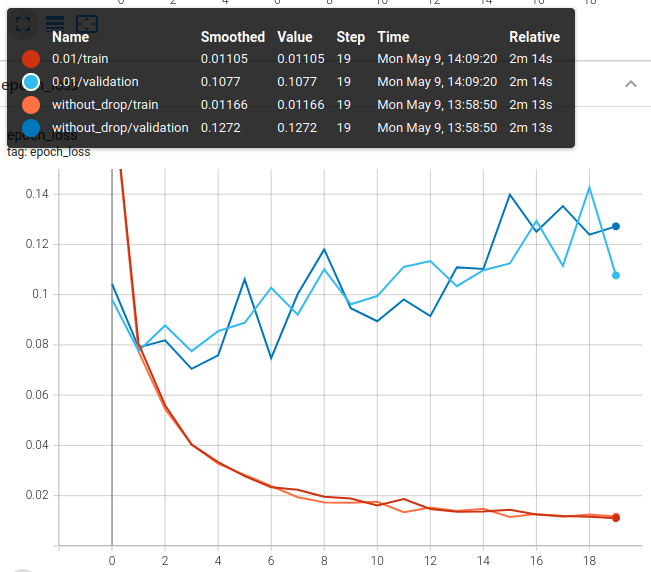

На графіку втрат можна спостерігати, що модель без дропауту навчається так само як і модель з використанням дропауту з малою (p->0) ймовірностю відключення нейронів. А також спостерігається перенавчання моделі. І для того щоб позбутися даного перенавчання використовується модель з дропаутом та використання більшого коефіцієнта р.

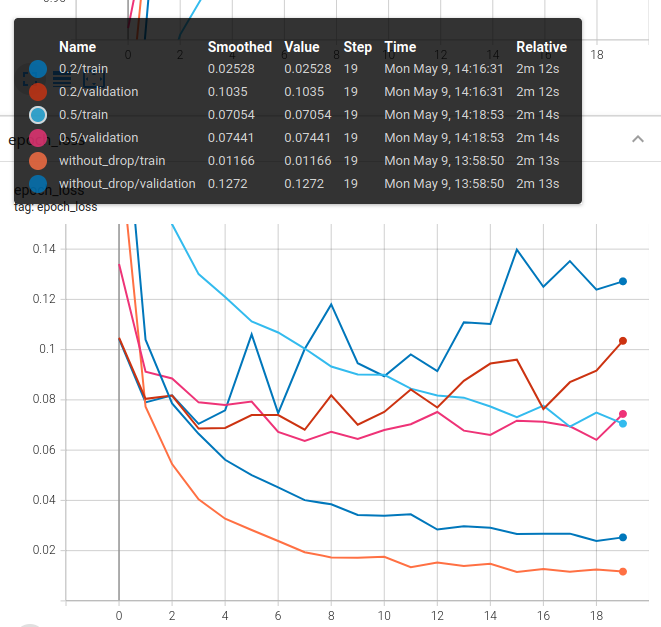

Як видно з вище наведеног графіка втрат чим вище коефіцієнт ймовірності відключення нейронів, то модель є менш перенавченою, але для того щоб таку модель начити потрібно більше епох навчання. 

In [112]:
%tensorboard --logdir logs

In [111]:
!kill 85434

#### Early stopping

Я уже згадув вище, що коли модель надто охоче вивчає шум, функція втрат перевірки може почати збільшуватися під час навчання. Щоб запобігти цьому, ми можемо просто припинити навчання, коли втрата на первірочні множині більше не зменшується. Переривання навчання таким чином називається ранньою зупинкою. </br>
Як тільки ми виявимо, що функція втрат перевірки знову починає зростати, ми можемо скинути ваги назад до мінімуму. Це гарантує, що модель не буде продовжувати вивчати шум і переповнювати модель не потрібними даними. 

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(512, input_shape=[28*28],
                 activation=activation_relu,
                 kernel_initializer=initializer_he),
    layers.Dropout(0.5),
    layers.Dense(256, activation=activation_relu,
                kernel_initializer=initializer_he),
    layers.Dropout(0.5),
    layers.Dense(units=10, activation='softmax'),
    ])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=metrics
    )
    
logdir = os.path.join("logs/early_stop",)

callback_list = [
    keras.callbacks.TensorBoard(
        logdir, histogram_freq=1
    ),
    keras.callbacks.EarlyStopping(
        min_delta=0.001, patience=20, restore_best_weights=True
    )
]

history = model.fit(X_train,y_train, 
                        validation_data=(X_valid, y_valid),
                        epochs=30,
                        callbacks=[callback_list])
      
model.save('models/model_early_stop')

Epoch 1/30
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2879 - accuracy: 0.9115 - f1: 0.8139 - auc: 0.9765 - val_loss: 0.1017 - val_accuracy: 0.9693 - val_f1: 0.9691 - val_auc: 0.9987
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1495 - accuracy: 0.9557 - f1: 0.9552 - auc: 0.9970 - val_loss: 0.0904 - val_accuracy: 0.9720 - val_f1: 0.9717 - val_auc: 0.9987
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1216 - accuracy: 0.9632 - f1: 0.9629 - auc: 0.9976 - val_loss: 0.0798 - val_accuracy: 0.9751 - val_f1: 0.9748 - val_auc: 0.9986
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1039 - accuracy: 0.9684 - f1: 0.9682 - auc: 0.9980 - val_loss: 0.0773 - val_accuracy: 0.9777 - val_f1: 0.9775 - val_auc: 0.9985
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0938 - accuracy: 0.9717 - f1: 0.9714 - auc: 0.9982 - val_loss: 0.0724 - val_accuracy: 0.9781 - va

INFO:tensorflow:Assets written to: models/model_early_stop/assets


In [97]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss            0.039766
accuracy        0.988550
f1              0.988464
auc             0.999057
val_loss        0.089356
val_accuracy    0.982900
val_f1          0.982790
val_auc         0.996995
dtype: float64

In [101]:
score = model.evaluate(X_valid, y_valid)

313/313 [==============================] - 1s 2ms/step - loss: 0.0894 - accuracy: 0.9829 - f1: 0.9828 - auc: 0.9970


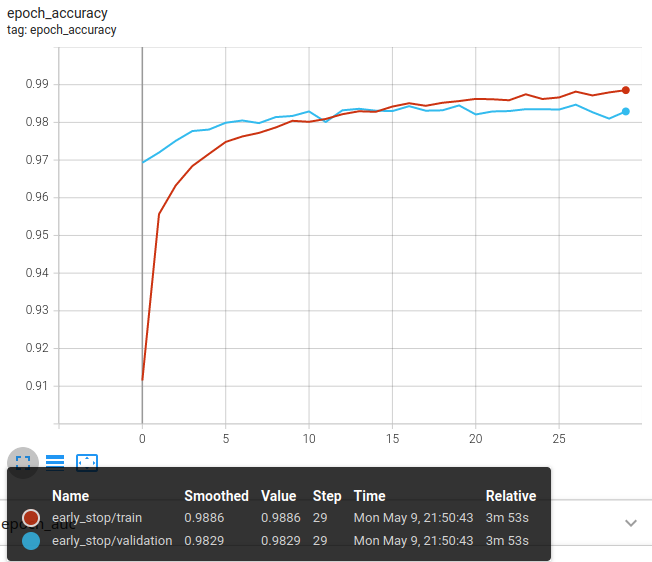
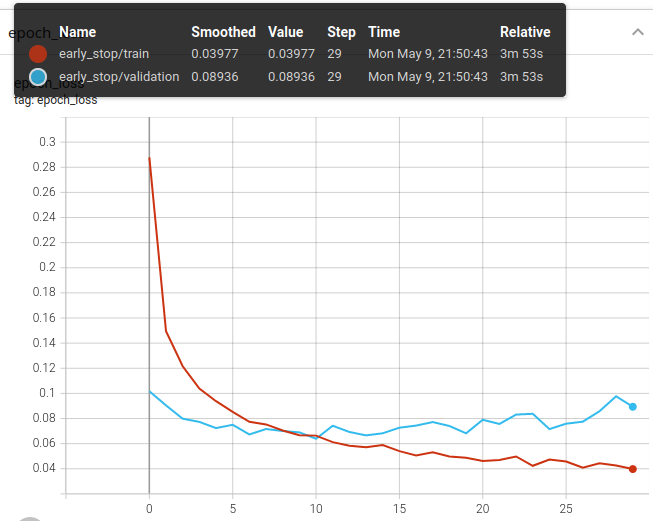

Створимо ще моделі із застосуванням регуляризацій

In [107]:
res_reg = pd.DataFrame()
res_reg["without"] = res["p=0.5"]

for regularization in['l2', 'l1']:

    model = keras.Sequential([
        layers.Dense(512, input_shape=[28*28],
                    activation=activation_relu,
                    kernel_initializer=initializer_he,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization
                    ),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation_relu,
                    kernel_initializer=initializer_he,
                    kernel_regularizer=regularization,
                    bias_regularizer=regularization
                    ),
        layers.Dropout(0.5),
        layers.Dense(units=10, activation='softmax'),
        ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics=metrics
        )

    logdir = os.path.join("logs/regularization", regularization)

    callback_list = [
        keras.callbacks.TensorBoard(
            logdir, histogram_freq=1
        ),
        keras.callbacks.EarlyStopping(
            min_delta=0.001, patience=20, restore_best_weights=True
        )
    ]

    history = model.fit(X_train,y_train, 
                            validation_data=(X_valid, y_valid),
                            epochs=30,
                            callbacks=[callback_list])
    
    res_reg[regularization] = pd.Series({i:j[-1] for i, j in history.history.items()})

    model.save(f'models/model_r{regularization}')

Epoch 1/30
1875/1875 [==============================] - 12s 6ms/step - loss: 1.5782 - accuracy: 0.8535 - f1: 0.8555 - auc: 0.9863 - val_loss: 0.7098 - val_accuracy: 0.9134 - val_f1: 0.9117 - val_auc: 0.9946
Epoch 2/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8166 - accuracy: 0.8788 - f1: 0.8771 - auc: 0.9891 - val_loss: 0.6624 - val_accuracy: 0.9236 - val_f1: 0.9227 - val_auc: 0.9955
Epoch 3/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7725 - accuracy: 0.8845 - f1: 0.8830 - auc: 0.9898 - val_loss: 0.6328 - val_accuracy: 0.9305 - val_f1: 0.9299 - val_auc: 0.9956
Epoch 4/30
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7507 - accuracy: 0.8886 - f1: 0.8873 - auc: 0.9904 - val_loss: 0.6081 - val_accuracy: 0.9353 - val_f1: 0.9344 - val_auc: 0.9966
Epoch 5/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.7393 - accuracy: 0.8901 - f1: 0.8887 - auc: 0.9902 - val_loss: 0.5719 - val_accuracy: 0.9395 -

INFO:tensorflow:Assets written to: models/model_rl2/assets


Epoch 1/30
1875/1875 [==============================] - 11s 6ms/step - loss: 7.5323 - accuracy: 0.1314 - f1: 0.2527 - auc: 0.6557 - val_loss: 2.8918 - val_accuracy: 0.1135 - val_f1: 0.0204 - val_auc: 0.5141
Epoch 2/30
1875/1875 [==============================] - 10s 5ms/step - loss: 2.8894 - accuracy: 0.1124 - f1: 0.0202 - auc: 0.5131 - val_loss: 2.8876 - val_accuracy: 0.1135 - val_f1: 0.0204 - val_auc: 0.5158
Epoch 3/30
1875/1875 [==============================] - 10s 6ms/step - loss: 2.8868 - accuracy: 0.1124 - f1: 0.0202 - auc: 0.5129 - val_loss: 2.8847 - val_accuracy: 0.1135 - val_f1: 0.0204 - val_auc: 0.5157
Epoch 4/30
1875/1875 [==============================] - 10s 5ms/step - loss: 2.8855 - accuracy: 0.1124 - f1: 0.0202 - auc: 0.5135 - val_loss: 2.8868 - val_accuracy: 0.1135 - val_f1: 0.0204 - val_auc: 0.5157
Epoch 5/30
1875/1875 [==============================] - 10s 5ms/step - loss: 2.8848 - accuracy: 0.1124 - f1: 0.0202 - auc: 0.5135 - val_loss: 2.8856 - val_accuracy: 0.1135 

INFO:tensorflow:Assets written to: models/model_rl1/assets


In [108]:
res_reg

,without,l2,l1
loss,0.061311,0.714834,2.880556
accuracy,0.982833,0.891200,0.112300
f1,0.982686,0.889967,0.020805
auc,0.998538,0.989810,0.512923
val_loss,0.078169,0.562570,2.880627
val_accuracy,0.981100,0.937600,0.113500
val_f1,0.980905,0.936731,0.020386
val_auc,0.997620,0.995624,0.514139


Модель без регуляризації даних є більш точною моделю

Отже виберемо найкращу модель 

In [113]:
model = keras.Sequential([
        layers.Dense(512, input_shape=[28*28],
                    activation=activation_relu,
                    kernel_initializer=initializer_he
                    ),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation_relu,
                    kernel_initializer=initializer_he
                    ),
        layers.Dropout(0.5),
        layers.Dense(units=10, activation='softmax'),
        ])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics=metrics
        )

logdir = os.path.join("logs/regularization", regularization)

callback_list = [
        keras.callbacks.TensorBoard(
            logdir, histogram_freq=1
        ),
        keras.callbacks.EarlyStopping(
            min_delta=0.001, patience=20, restore_best_weights=True
        )
    ]

history = model.fit(X_train,y_train, 
                            validation_data=(X_valid, y_valid),
                            epochs=30,
                            callbacks=[callback_list])
    
    
model.save('models/model_final')

Epoch 1/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3496 - accuracy: 0.8919 - f1: 0.7956 - auc: 0.9728 - val_loss: 0.1235 - val_accuracy: 0.9612 - val_f1: 0.9609 - val_auc: 0.9979
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1834 - accuracy: 0.9459 - f1: 0.9453 - auc: 0.9958 - val_loss: 0.1075 - val_accuracy: 0.9672 - val_f1: 0.9667 - val_auc: 0.9985
Epoch 3/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1521 - accuracy: 0.9549 - f1: 0.9544 - auc: 0.9967 - val_loss: 0.0847 - val_accuracy: 0.9744 - val_f1: 0.9743 - val_auc: 0.9988
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1359 - accuracy: 0.9593 - f1: 0.9589 - auc: 0.9971 - val_loss: 0.0826 - val_accuracy: 0.9728 - val_f1: 0.9726 - val_auc: 0.9989
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1227 - accuracy: 0.9635 - f1: 0.9632 - auc: 0.9973 - val_loss: 0.0740 - val_accuracy: 0.9774 - v

INFO:tensorflow:Assets written to: models/model_final/assets


### Протестуємо на перевірочних даних

In [4]:
model = keras.models.load_model('models/model_final')

In [3]:
(X_train, y_train), (X_valid, y_valid) = mnist.load_data()

In [5]:
def create_table(ax, y_true, y_pred):
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y_pred = y_pred.ravel()
    
    table = [[label, proba] for label, proba in zip(labels, y_pred)]
    colours = [['w', 'w'] for _ in labels]
    colours[y_true][0] = 'g'
    if y_pred.argmax() == y_true:
        colours[y_pred.argmax()][1] = 'g'
    else:
        colours[y_pred.argmax()][1] = 'r'
        
    table = ax.table(table, loc='center',
                   cellLoc='left', cellColours = colours)
    table.set_fontsize(12)
    ax.axis('off')

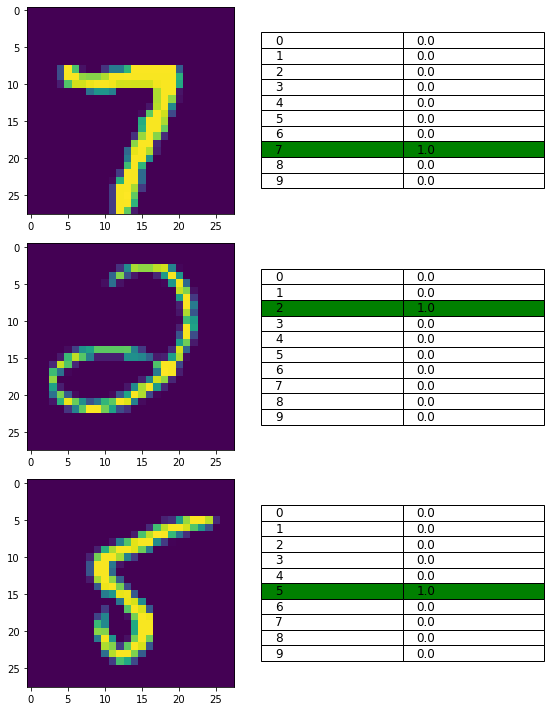

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

indexes = np.random.randint(len(y_valid), size=3)

for l, i in enumerate(indexes):
    ax[l, 0].imshow(X_valid[i])
    
    prediction = model.predict(X_valid[i].reshape(-1, 28*28))
    create_table(ax[l, 1], y_valid[i], prediction)

plt.tight_layout()

Додамо нове зображення

In [56]:
def pred_images(image_path, y_true):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    orig_img = tf.keras.preprocessing.image.load_img(image_path)
    ax[0].imshow(orig_img)
    
    image = tf.keras.preprocessing.image.load_img(image_path,  
                                                         color_mode='grayscale', 
                                                         target_size=(28, 28))
    
    img_arr = keras.preprocessing.image.img_to_array(image)
    X = (255.0 - img_arr) / 255.0
    ax[1].imshow(X)
    print()
    pred = model.predict(X.reshape(-1, 28*28))
    create_table(ax[2], y_true, pred)
    
    ax[0].set_title('Original', fontsize=16)
    ax[1].set_title('Preprocessed', fontsize=16)
    ax[2].set_title('Prediction', fontsize=16)

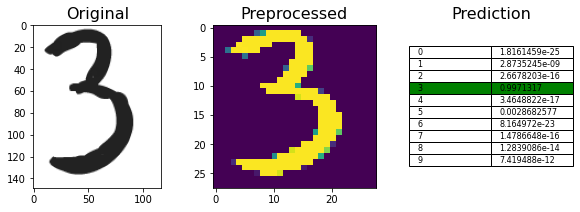

In [57]:
import cv2
image_path = 'mnist/3.png'
y_true = 3
pred_images(image_path, y_true)

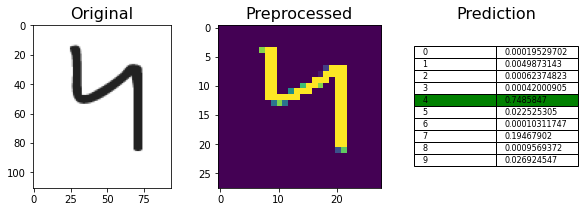

In [58]:
image_path = 'mnist/4.png'
y_true = 4
pred_images(image_path, y_true)

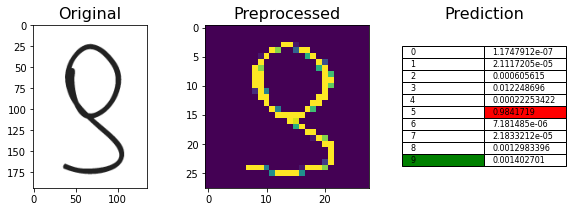

In [79]:
image_path = 'mnist/9.png'
y_true = 9
pred_images(image_path, y_true)

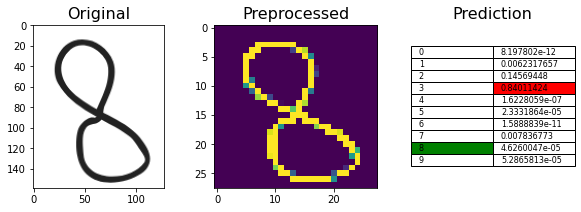

In [81]:
image_path = 'mnist/8.png'
y_true = 8
pred_images(image_path, y_true)

### Висновок 
Протягом даної лабораторної роботи було досліджено та побудовоні моделі для визначення чисел на наборі даних mnist. Після дослідження було визначено таку модель:

In [80]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 512)               401920    
                                                                 
 dropout_46 (Dropout)        (None, 512)               0         
                                                                 
 dense_111 (Dense)           (None, 256)               131328    
                                                                 
 dropout_47 (Dropout)        (None, 256)               0         
                                                                 
 dense_112 (Dense)           (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


Під час тестування моделі можна побачити, що модель все таки допускає неточності під час прогнозування. Але все таки це є непоганим результатом для такої простої моделі метою якої є розподіл на 10 класів